# Entraînement des modèles de classification

## 1 - Manipulation et preprocessing des données

On définit une classe pour manipuler le dataset d'images de HappyBud.

In [1]:
import torch
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2 as transforms_v2
from PIL import Image
import pathlib


In [2]:
dataset_files = {
    "tomato": "tomato_dataset_v2.csv",
    "corn": "corn_dataset.csv",
    "potato": "potato_dataset.csv"
}

datasets = []

path = pathlib.Path("dataset")

for key, val in dataset_files.items():
    tmp_dataset = pd.read_csv(path / val, index_col=0)
    tmp_dataset["plant"] = key
    datasets.append(tmp_dataset)

dataset = pd.concat(datasets, axis=0, ignore_index=True)
dataset["plantclass"] = dataset["plant"] + "_" + dataset["class"]

dataset

,filename,source,subset,class,plant,plantclass
0,IMG20220323104920.jpg,tomato_village,test,early_blight,tomato,tomato_early_blight
1,IMG20220323132208.jpg,tomato_village,train,early_blight,tomato,tomato_early_blight
2,IMG20220323183239.jpg,tomato_village,train,early_blight,tomato,tomato_early_blight
3,IMG20220324121417.jpg,tomato_village,train,early_blight,tomato,tomato_early_blight
4,IMG20220324175323.jpg,tomato_village,train,early_blight,tomato,tomato_early_blight
...,...,...,...,...,...,...
31358,Po_lt_blight_(653).jpg,nzdl,train,late_blight,potato,potato_late_blight
31359,Po_lt_blight_(654).jpg,nzdl,train,late_blight,potato,potato_late_blight
31360,Po_lt_blight_(655).jpg,nzdl,train,late_blight,potato,potato_late_blight
31361,Po_lt_blight_(656).jpg,nzdl,train,late_blight,potato,potato_late_blight


In [3]:
class HappyBudDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, root_dir, classes, subset="train", label_col="plantclass", transform=None):
        """
        Args:
            csv_file (str): Path to the CSV file.
            root_dir (str): Root directory containing train, val, and test folders.
            subset (str): One of 'train', 'val', or 'test'.
            transform (callable, optional): Transformations to apply to images.
        """
        self.df = dataframe

        self.df[label_col] = self.df[label_col].astype(pd.CategoricalDtype(categories=classes))

        # Filter dataset based on 'train', 'val', or 'test'
        self.df = self.df[self.df["subset"] == subset]

        # One-hot encoding of labels
        self.labels = pd.get_dummies(self.df[label_col])

        self.root_dir = pathlib.Path(root_dir)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Get image path
        img_name = self.df["filename"].iloc[idx]
        plant_name = self.df["plant"].iloc[idx]
        img_path = self.root_dir / plant_name / img_name

        # Load image
        image = Image.open(img_path).convert("RGB")

        # Apply transformations
        if self.transform:
            image = self.transform(image)

        # Load labels (convert to tensor)
        labels = torch.tensor(self.labels.iloc[idx].values, dtype=torch.float32)

        return image, labels


# Define transformations
transform = transforms_v2.Compose(
    [
        transforms_v2.ToImage(),  # Convert to image tensor
        transforms_v2.ToDtype(torch.float32, scale=True),  # Convert dtype to float32
        transforms_v2.Resize((224, 224)),  # Resize images to match model input
    ]
)

# Create dataset
root_dir = "dataset/"
classes = dataset["plantclass"].unique()

train_dataset = HappyBudDataset(dataset, root_dir, classes, subset="train", transform=transform)

# Create DataLoader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

# Test the dataset
for images, labels in train_loader:
    print(images.shape)  # Should be (batch_size, 3, 224, 224)
    print(labels.shape)  # Should be (batch_size, num_classes)
    break

torch.Size([32, 3, 224, 224])
torch.Size([32, 18])


On définit un pipeline pour l'entraînement des données. Ce pipeline se base sur cette
[page](https://pytorch.org/vision/stable/auto_examples/transforms/plot_transforms_getting_started.html)
qui définit les bonnes pratiques pour différentes tâches de vision. On se base aussi en
partie sur le [pipeline](https://pytorch.org/vision/stable/models/generated/torchvision.models.vit_b_16.html#torchvision.models.ViT_B_16_Weights)
qui a été utilisé pour entraîner le modèle sur ImageNet1K.

Voici les étapes du pipeline:
- Conversion en tenseur
- Changement du type de données pour float32
- Redimensionnement en images 256x256 (légèrement plus gros que l'entrée)
- Rotation aléatoire
- Réflexion horizontale aléatoire
- Recadrage (crop) aléatoire en 224x224
- Normalisation selon la moyenne et l'écart type de ImageNet1K

In [5]:
# Training pipeline
transformations = [
    # Conversion to float32 image tensor
    transforms_v2.ToImage(),
    transforms_v2.ToDtype(torch.float32, scale=True),
    # Data augmentation
    transforms_v2.Resize((256, 256), antialias=True),
    transforms_v2.RandomHorizontalFlip(p=0.5),
    transforms_v2.RandomRotation(
        degrees=(0, 360)
    ),  # , interpolation=transforms_v2.InterpolationMode.BILINEAR),
    transforms_v2.RandomCrop(size=(224, 224)),
    # Normalization for ViT, valeurs de ImageNet1K
    transforms_v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
]

training_pipeline = transforms_v2.Compose(transformations)

# Pour l'affichage des images, on ne doit pas normaliser
dummy_pipeline = transforms_v2.Compose(transformations[:-1])

Visualisation des images après les transformations.

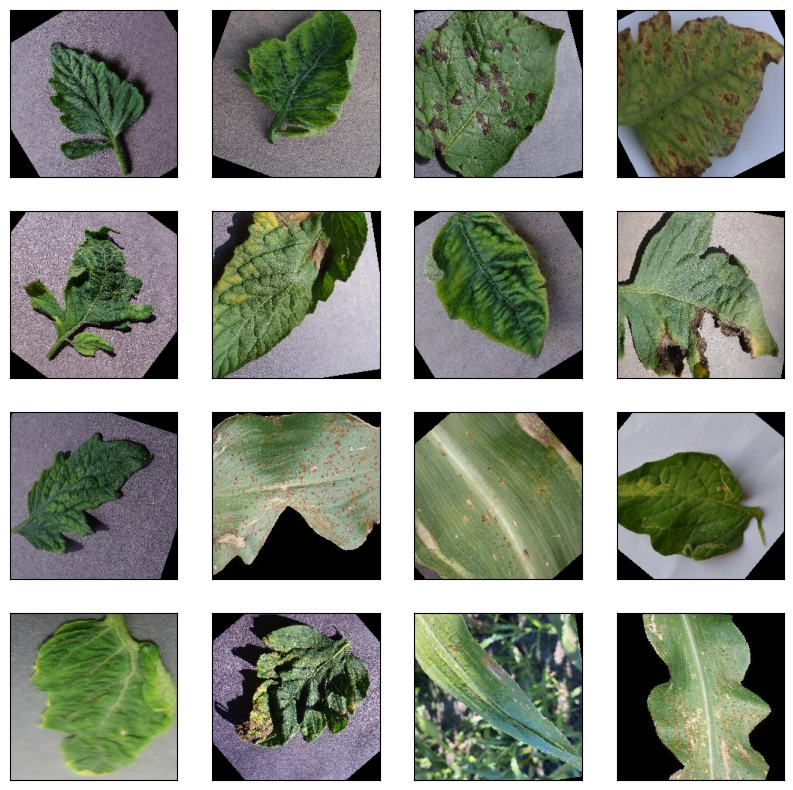

In [6]:
# Visualisation de quelques images après passage du pipeline
import matplotlib.pyplot as plt

dummy_train_dataset = HappyBudDataset(
    dataset, root_dir, classes, subset="train", transform=dummy_pipeline
)
dummy_train_loader = DataLoader(dummy_train_dataset, batch_size=16, shuffle=True)

images, labels = next(iter(dummy_train_loader))

fig, axes = plt.subplots(4, 4, figsize=(10, 10))

for i, image in enumerate(images):
    ax = axes.flatten()[i]
    ax.imshow(image.moveaxis(0, -1))
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])

## 2 - Entraînement du modèle

In [4]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms

# import timm
from torchvision.models import mobilenet_v3_large

In [25]:
# Create dataset
root_dir = "dataset/"
classes = dataset["plantclass"].unique()

# Load datasets
train_dataset = HappyBudDataset(
    dataset, root_dir, classes, subset="train", transform=training_pipeline
)
test_dataset = HappyBudDataset(
    dataset, root_dir, classes, subset="test", transform=training_pipeline
)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
classes

['tomato_early_blight', 'tomato_healthy', 'tomato_late_blight', 'tomato_leaf_miner', 'tomato_nutrient_deficiency', ..., 'corn_streak_virus', 'corn_common_rust', 'potato_healthy', 'potato_early_blight', 'potato_late_blight']
Length: 18
Categories (18, object): ['tomato_early_blight', 'tomato_healthy', 'tomato_late_blight', 'tomato_leaf_miner', ..., 'corn_common_rust', 'potato_healthy', 'potato_early_blight', 'potato_late_blight']

In [26]:
# Load pretrained MobileNet v3
num_labels = len(train_dataset.labels.columns)  # Get number of labels (e.g., 8)

model = mobilenet_v3_large(weights="IMAGENET1K_V1")  # Load a pretrained model
model.classifier[3] = nn.Linear(
    model.classifier[3].in_features, num_labels
)  # Modify last layer

In [27]:
# Calcul du nombre d'images par classes
image_numbers = train_dataset.df["plantclass"].value_counts()[train_dataset.labels.columns]
image_numbers

tomato_early_blight               743
tomato_healthy                   1745
tomato_late_blight               1508
tomato_leaf_miner                 717
tomato_nutrient_deficiency        120
tomato_spotted_wilt_virus         362
tomato_septoria_leaf_spot        3160
tomato_verticillium_wilt          540
tomato_mosaic_virus               261
tomato_yellow_leaf_curl_virus    3750
corn_healthy                     1148
corn_leaf_spot                   2652
corn_leaf_blight                 1868
corn_streak_virus                 676
corn_common_rust                  934
potato_healthy                    245
potato_early_blight               783
potato_late_blight                740
Name: count, dtype: int64

In [28]:
# Calcul du poids pour la calibration
weights = torch.tensor(image_numbers.sum() / (image_numbers.values * len(image_numbers)))
weights

tensor([ 1.6414,  0.6989,  0.8087,  1.7009, 10.1630,  3.3689,  0.3859,  2.2584,
         4.6726,  0.3252,  1.0623,  0.4599,  0.6529,  1.8041,  1.3057,  4.9778,
         1.5575,  1.6480], dtype=torch.float64)

In [29]:
# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(device)

# Loss function & optimizer
criterion = nn.CrossEntropyLoss(weight=weights.to(device))
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

cuda


In [15]:
# Training function
def train_model(model, train_loader, criterion, optimizer, epochs=10):
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        correct = 0.0

        for images, labels in train_loader:
            # Compute loss
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)  # Logits
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            # Compute number of correct images
            prediction = torch.argmax(outputs, axis=1)
            label = torch.argmax(labels, axis=1)
            correct += (prediction == label).sum()

        avg_train_loss = train_loss / len(train_loader)
        train_accuracy = correct / len(train_loader.dataset)

        print(
            f"Epoch [{epoch+1}/{epochs}] | Train Loss: {avg_train_loss:.4f} | Train Accuracy: {train_accuracy:.4f}"
        )

In [ ]:
# Train for 10 epochs
train_model(model, train_loader, criterion, optimizer, epochs=10)

In [31]:
import pathlib

pathlib.Path("models").mkdir(exist_ok=True)

# Save model
torch.save(model.state_dict(), "models/generalist_model_2025_03_27.pt")

## 3 - Validation du modèle sur les données de test

In [32]:
import torch

# Load fine-tuned ViT
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_labels = len(test_dataset.labels.columns)  # Get number of labels (e.g., 8)

model = mobilenet_v3_large()
model.classifier[3] = nn.Linear(
    model.classifier[3].in_features, num_labels
)  # Modify last layer

model.load_state_dict(
    torch.load(
        "models/generalist_model_2025_03_27.pt",
        map_location=device,
        weights_only=True,
    )
)

<All keys matched successfully>

In [20]:
import numpy as np

def evaluate_model(model, test_loader, device):
    model.eval()  # Set to evaluation mode
    all_labels = []
    all_preds = []

    with torch.no_grad():  # No gradients needed
        for images, labels in test_loader:
            model = model.to(device)
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            preds = torch.argmax(outputs, axis=1)
            labels = torch.argmax(labels, axis=1)

            all_labels.append(labels.cpu().numpy())  # Store true labels
            all_preds.append(preds.cpu().numpy())  # Store predictions

    # Convert lists to numpy arrays
    all_labels = np.concatenate(all_labels, axis=0)
    all_preds = np.concatenate(all_preds, axis=0)

    return all_labels, all_preds

In [34]:
# Evaluate model
labels, preds = evaluate_model(model, test_loader, device)

In [35]:
# Accuracy sur les données de test
(labels == preds).sum() / len(labels)

np.float64(0.901604505366061)

In [37]:
# Copy predictions into dataframe
test_results = test_dataset.df.copy()
assert np.all(test_results["plantclass"].cat.codes == labels)

classes = np.array(test_dataset.labels.columns)

test_results["pred"] = pd.Series(
    pd.Categorical(
        classes[preds],
        categories=classes,
    ),
    index=test_results.index,
)

test_results.to_csv("results/generalist_model_2025_03_27.csv")

## 4 - Transfer learning vers les plantes

In [38]:
import torch

# Load fine-tuned ViT
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_labels = len(test_dataset.labels.columns)  # Get number of labels (e.g., 8)

model = mobilenet_v3_large()
model.classifier[3] = nn.Linear(
    model.classifier[3].in_features, num_labels
)  # Modify last layer

model.load_state_dict(
    torch.load(
        "models/generalist_model_2025_03_27.pt",
        map_location=device,
        weights_only=True,
    )
)

<All keys matched successfully>

In [23]:
# Create dataset
root_dir = "dataset/"
classes = dataset["plant"].unique()

# Load datasets
train_dataset = HappyBudDataset(
    dataset, root_dir, classes, subset="train", transform=training_pipeline, label_col="plant"
)
test_dataset = HappyBudDataset(
    dataset, root_dir, classes, subset="test", transform=training_pipeline, label_col="plant"
)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
classes

array(['tomato', 'corn', 'potato'], dtype=object)

In [40]:
# Modify last layer again
model.classifier[3] = nn.Linear(
    model.classifier[3].in_features, len(classes)
)  # Modify last layer

In [41]:
# Disable gradient to all layers except classifier
for name, param in model.named_parameters():
    if "classifier" not in name:
        print(f"Disabling gradient for parameter {name}")
        param.requires_grad = False
    else:
        print(f"Keeping gradient for parameter {name}")
        param.requires_grad = True

Disabling gradient for parameter features.0.0.weight
Disabling gradient for parameter features.0.1.weight
Disabling gradient for parameter features.0.1.bias
Disabling gradient for parameter features.1.block.0.0.weight
Disabling gradient for parameter features.1.block.0.1.weight
Disabling gradient for parameter features.1.block.0.1.bias
Disabling gradient for parameter features.1.block.1.0.weight
Disabling gradient for parameter features.1.block.1.1.weight
Disabling gradient for parameter features.1.block.1.1.bias
Disabling gradient for parameter features.2.block.0.0.weight
Disabling gradient for parameter features.2.block.0.1.weight
Disabling gradient for parameter features.2.block.0.1.bias
Disabling gradient for parameter features.2.block.1.0.weight
Disabling gradient for parameter features.2.block.1.1.weight
Disabling gradient for parameter features.2.block.1.1.bias
Disabling gradient for parameter features.2.block.2.0.weight
Disabling gradient for parameter features.2.block.2.1.weig

In [42]:
# Calcul du nombre d'images par classes
image_numbers = train_dataset.df["plant"].value_counts()[train_dataset.labels.columns]
image_numbers

tomato    12906
corn       7278
potato     1768
Name: count, dtype: int64

In [43]:
# Calcul du poids pour la calibration
weights = torch.tensor(image_numbers.sum() / (image_numbers.values * len(image_numbers)))
weights

tensor([0.5670, 1.0054, 4.1388], dtype=torch.float64)

In [44]:
# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(device)

# Loss function & optimizer
criterion = nn.CrossEntropyLoss(weight=weights.to(device))
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

cuda


In [45]:
# Train for 10 epochs
train_model(model, train_loader, criterion, optimizer, epochs=10)

Epoch [1/10] | Train Loss: 0.0531 | Train Accuracy: 0.9815
Epoch [2/10] | Train Loss: 0.0198 | Train Accuracy: 0.9927


KeyboardInterrupt: 

In [ ]:
import pathlib

pathlib.Path("models").mkdir(exist_ok=True)

# Save model
torch.save(model.state_dict(), "models/generalist_model_plants_2025_03_27.pt")

In [24]:
import torch

# Load fine-tuned ViT
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_labels = len(test_dataset.labels.columns)  # Get number of labels (e.g., 8)

model = mobilenet_v3_large()
model.classifier[3] = nn.Linear(
    model.classifier[3].in_features, num_labels
)  # Modify last layer

model.load_state_dict(
    torch.load(
        "models/generalist_model_plants_2025_03_27.pt",
        map_location=device,
        weights_only=True,
    )
)

<All keys matched successfully>

In [25]:
# Evaluate model
labels, preds = evaluate_model(model, test_loader, device)

# Accuracy sur les données de test
(labels == preds).sum() / len(labels)

np.float64(0.9991499309318882)

In [26]:
# Copy predictions into dataframe
test_results = test_dataset.df.copy()
assert np.all(test_results["plant"].cat.codes == labels)

classes = np.array(test_dataset.labels.columns)

test_results["pred"] = pd.Series(
    pd.Categorical(
        classes[preds],
        categories=classes,
    ),
    index=test_results.index,
)

test_results.to_csv("results/generalist_model_plants_2025_03_27.csv")

## 5 - Transfer learning vers les tomates

In [7]:
import torch

# Load fine-tuned ViT
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_labels = len(dataset["plantclass"].unique())  # Get number of labels (e.g., 8)

model = mobilenet_v3_large()
model.classifier[3] = nn.Linear(
    model.classifier[3].in_features, num_labels
)  # Modify last layer

model.load_state_dict(
    torch.load(
        "models/generalist_model_2025_03_27.pt",
        map_location=device,
        weights_only=True,
    )
)

<All keys matched successfully>

In [8]:
import numpy as np

def sample_dataset(dataset, images_per_class, random_seed=None):
    rng = np.random.default_rng(random_seed)

    modified_dataset = []

    for c in classes:
        # Find subset
        subset = dataset.loc[dataset["class"] == c]

        # Get sequence permutation
        seq = rng.permutation(len(subset))

        # Get number of repetition
        repetitions = 1 + (images_per_class // len(subset))

        # Tile the sequence and select the first elements
        seq = np.tile(seq, repetitions)[0:images_per_class]

        # Create a temporary dataset
        tmp_dataset = subset.iloc[seq]
        modified_dataset.append(tmp_dataset)

    modified_dataset = pd.concat(modified_dataset, axis=0, ignore_index=True)
    
    return modified_dataset

In [9]:
# Create dataset
root_dir = "dataset/"
tomato_subset = dataset.query("plant == 'tomato'").copy()
classes = tomato_subset["class"].unique()

train_subset = sample_dataset(tomato_subset.query("subset == 'train'"), 2000, 45678910)
train_subset = train_subset.drop("plant", axis=1)
train_subset["plant"] = "tomato"

# Load datasets
train_dataset = HappyBudDataset(
    train_subset, root_dir, classes, subset="train", transform=training_pipeline, label_col="class"
)
test_dataset = HappyBudDataset(
    tomato_subset, root_dir, classes, subset="test", transform=training_pipeline, label_col="class"
)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
classes

array(['early_blight', 'healthy', 'late_blight', 'leaf_miner',
       'nutrient_deficiency', 'spotted_wilt_virus', 'septoria_leaf_spot',
       'verticillium_wilt', 'mosaic_virus', 'yellow_leaf_curl_virus'],
      dtype=object)

In [11]:
# Modify last layer again
model.classifier[3] = nn.Linear(
    model.classifier[3].in_features, len(classes)
)  # Modify last layer

In [12]:
# Disable gradient to all layers except classifier
for name, param in model.named_parameters():
    if "classifier" not in name:
        print(f"Disabling gradient for parameter {name}")
        param.requires_grad = False
    else:
        print(f"Keeping gradient for parameter {name}")
        param.requires_grad = True

Disabling gradient for parameter features.0.0.weight
Disabling gradient for parameter features.0.1.weight
Disabling gradient for parameter features.0.1.bias
Disabling gradient for parameter features.1.block.0.0.weight
Disabling gradient for parameter features.1.block.0.1.weight
Disabling gradient for parameter features.1.block.0.1.bias
Disabling gradient for parameter features.1.block.1.0.weight
Disabling gradient for parameter features.1.block.1.1.weight
Disabling gradient for parameter features.1.block.1.1.bias
Disabling gradient for parameter features.2.block.0.0.weight
Disabling gradient for parameter features.2.block.0.1.weight
Disabling gradient for parameter features.2.block.0.1.bias
Disabling gradient for parameter features.2.block.1.0.weight
Disabling gradient for parameter features.2.block.1.1.weight
Disabling gradient for parameter features.2.block.1.1.bias
Disabling gradient for parameter features.2.block.2.0.weight
Disabling gradient for parameter features.2.block.2.1.weig

In [13]:
# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(device)

# Loss function & optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

cuda


In [16]:
# Train for 10 epochs
train_model(model, train_loader, criterion, optimizer, epochs=10)

Epoch [1/10] | Train Loss: 0.2309 | Train Accuracy: 0.9359
Epoch [2/10] | Train Loss: 0.1023 | Train Accuracy: 0.9658
Epoch [3/10] | Train Loss: 0.0933 | Train Accuracy: 0.9684
Epoch [4/10] | Train Loss: 0.0840 | Train Accuracy: 0.9722
Epoch [5/10] | Train Loss: 0.0788 | Train Accuracy: 0.9729
Epoch [6/10] | Train Loss: 0.0751 | Train Accuracy: 0.9732
Epoch [7/10] | Train Loss: 0.0724 | Train Accuracy: 0.9750
Epoch [8/10] | Train Loss: 0.0719 | Train Accuracy: 0.9742
Epoch [9/10] | Train Loss: 0.0660 | Train Accuracy: 0.9779
Epoch [10/10] | Train Loss: 0.0649 | Train Accuracy: 0.9764


In [17]:
import pathlib

pathlib.Path("models").mkdir(exist_ok=True)

# Save model
torch.save(model.state_dict(), "models/generalist_model_tomato_2025_03_27.pt")

In [18]:
import torch

# Load fine-tuned ViT
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_labels = len(test_dataset.labels.columns)  # Get number of labels (e.g., 8)

model = mobilenet_v3_large()
model.classifier[3] = nn.Linear(
    model.classifier[3].in_features, num_labels
)  # Modify last layer

model.load_state_dict(
    torch.load(
        "models/generalist_model_tomato_2025_03_27.pt",
        map_location=device,
        weights_only=True,
    )
)

<All keys matched successfully>

In [21]:
# Evaluate model
labels, preds = evaluate_model(model, test_loader, device)

# Accuracy sur les données de test
(labels == preds).sum() / len(labels)

np.float64(0.9557122198120029)

In [22]:
# Copy predictions into dataframe
test_results = test_dataset.df.copy()
assert np.all(test_results["class"].cat.codes == labels)

classes = np.array(test_dataset.labels.columns)

test_results["pred"] = pd.Series(
    pd.Categorical(
        classes[preds],
        categories=classes,
    ),
    index=test_results.index,
)

test_results.to_csv("results/generalist_model_tomato_2025_03_27.csv")